# Principle Component Analysis

This document is based on: [Principal Component Analysis from Scratch](https://bagheri365.github.io/blog/Principal-Component-Analysis-from-Scratch/)

There are some differences: 
- svd decomposition of the covariance matrix is used instead of the Eigen decomposition. Thus, the Eigen value and vector pairs are always in non-ascending order.
- Additional Eigen value correction is an optional step which is needed to obtain identical results with scikit-learn.

## What is PCA?

Greenacre, M., Groenen, P.J.F., Hastie, T. et al. Principal component analysis. Nat Rev Methods Primers 2, 100 (2022):
* PCA reduces a cases-by-variables data table to its essential features, called principal components. 
* Principal components are a few linear combinations of the original variables that maximally explain the variance of all the variables. 
* The method provides an approximation of the original data table using only these few major components.
    

## Preparations

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 8,
})

## Iris Dataset

The iris data is ideal for our learning purpose since the data has only 4 features: `sepal-length`, `sepal-width`, `petal-length`, and `petal-width`.

In [22]:
file_path = "./datasets/heart/Heart_Disease_Prediction.csv"
df = pd.read_csv(file_path)

# Menentukan fitur (X) dan label (y)
X = np.float32(df.iloc[:, :-1].values)  # Semua kolom kecuali kolom terakhir (label)
y = np.zeros(X.shape[0], dtype=np.int32) 

# Ubah label kategori menjadi angka
y[np.where(df.iloc[:, -1] == 'Presence')] = 1  # 'Presence' = 1 (Ada penyakit jantung)
y[np.where(df.iloc[:, -1] == 'Absence')]  = 0  # 'Absence' = 0 (Tidak ada penyakit jantung)

# Nama fitur
feature_names = df.columns[:-1].tolist()
n_features = X.shape[1]

# Print informasi dataset
print("Feature numbers :", X.shape[1])
print("Number of data  :", X.shape[0])
print("Labels          :", np.unique(y))


Feature numbers : 13
Number of data  : 270
Labels          : [0 1]


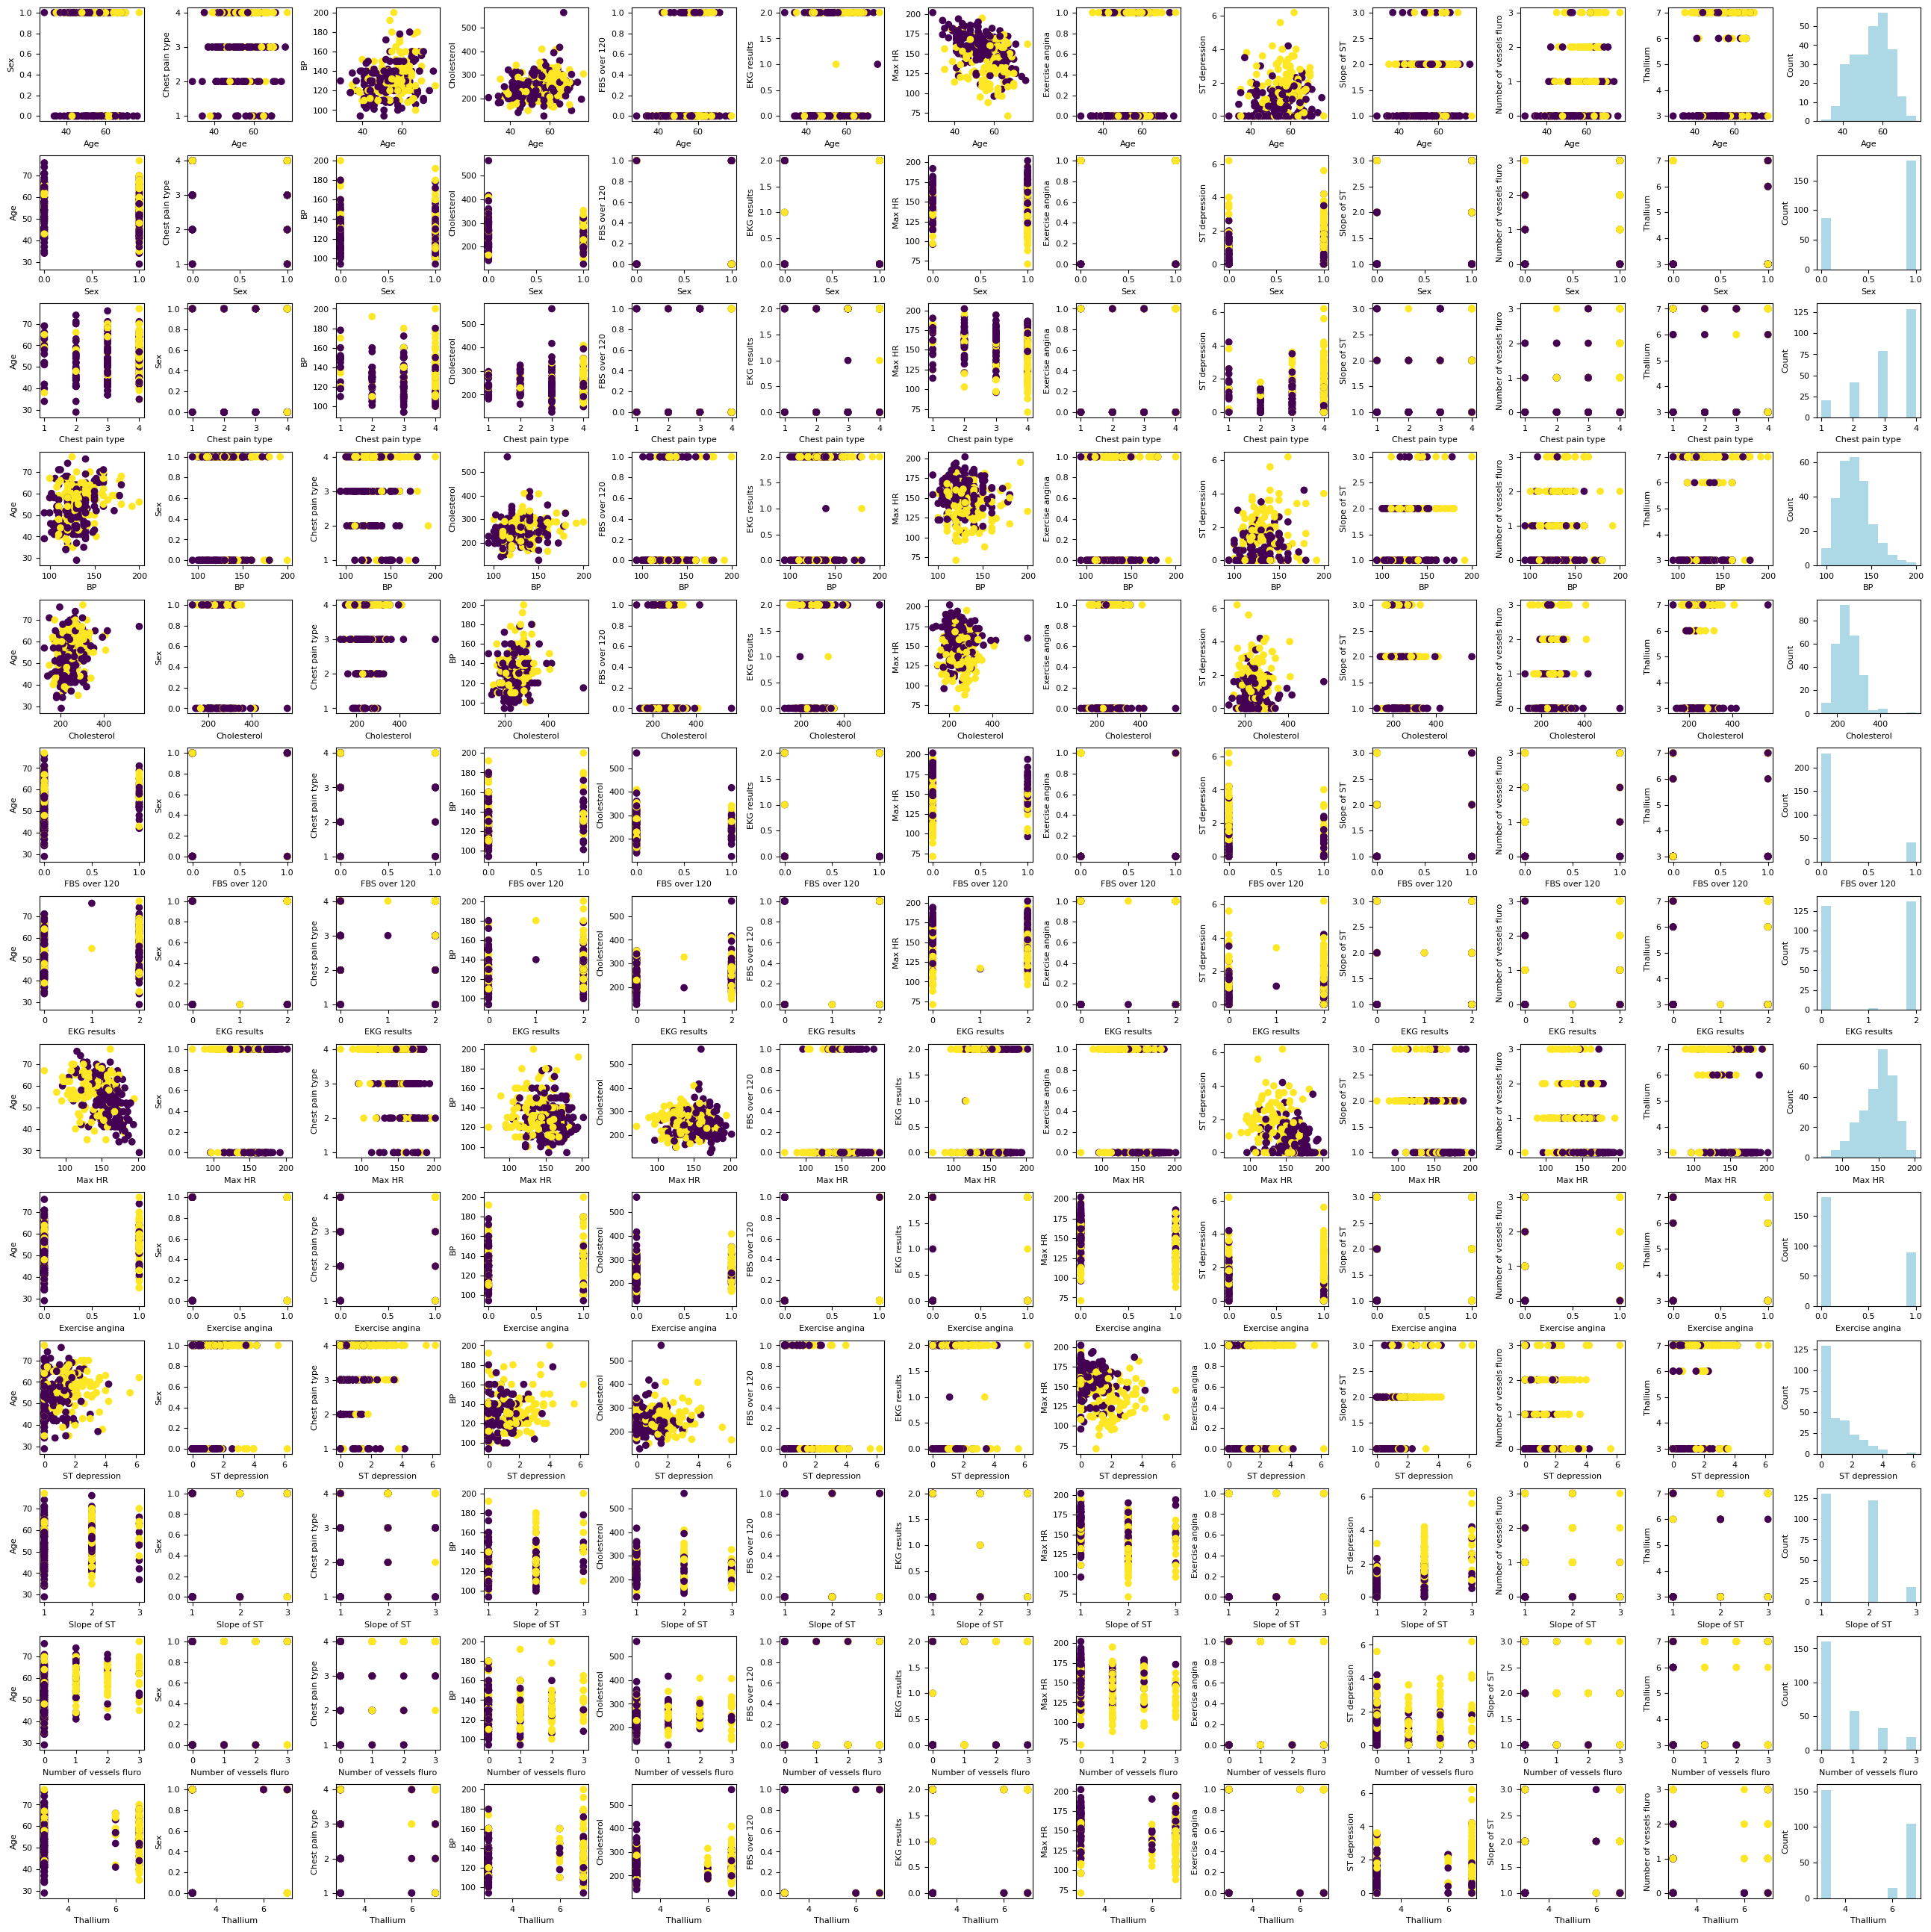

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(nrows=n_features, ncols=n_features, figsize= (n_features*2, n_features*2))
fig.tight_layout(pad=2.0)

names = feature_names

for i in range(n_features):
    J = np.arange(n_features)
    J = np.delete(J, i)
    for k, j in enumerate(J):
        ax[i, k].scatter(X[:, i], X[:, j], c = y)
        ax[i, k].set_xlabel(names[i])
        ax[i, k].set_ylabel(names[j])
        
for i in range(n_features):
    ax[i, -1].hist(X[:, i], color = 'lightblue')
    ax[i, -1].set_ylabel('Count')
    ax[i, -1].set_xlabel(names[i])

### Standardization

Definition:

$$ \mathrm{X}^{\prime}=\frac{\mathrm{X}-\text { Mean }}{\text { Standard deviation }} $$

In [23]:
means  = np.mean(X, axis=0)
stdevs = np.std(X, axis=0)

X_std = (X - means) / stdevs

Let us plot the standardized dataset.

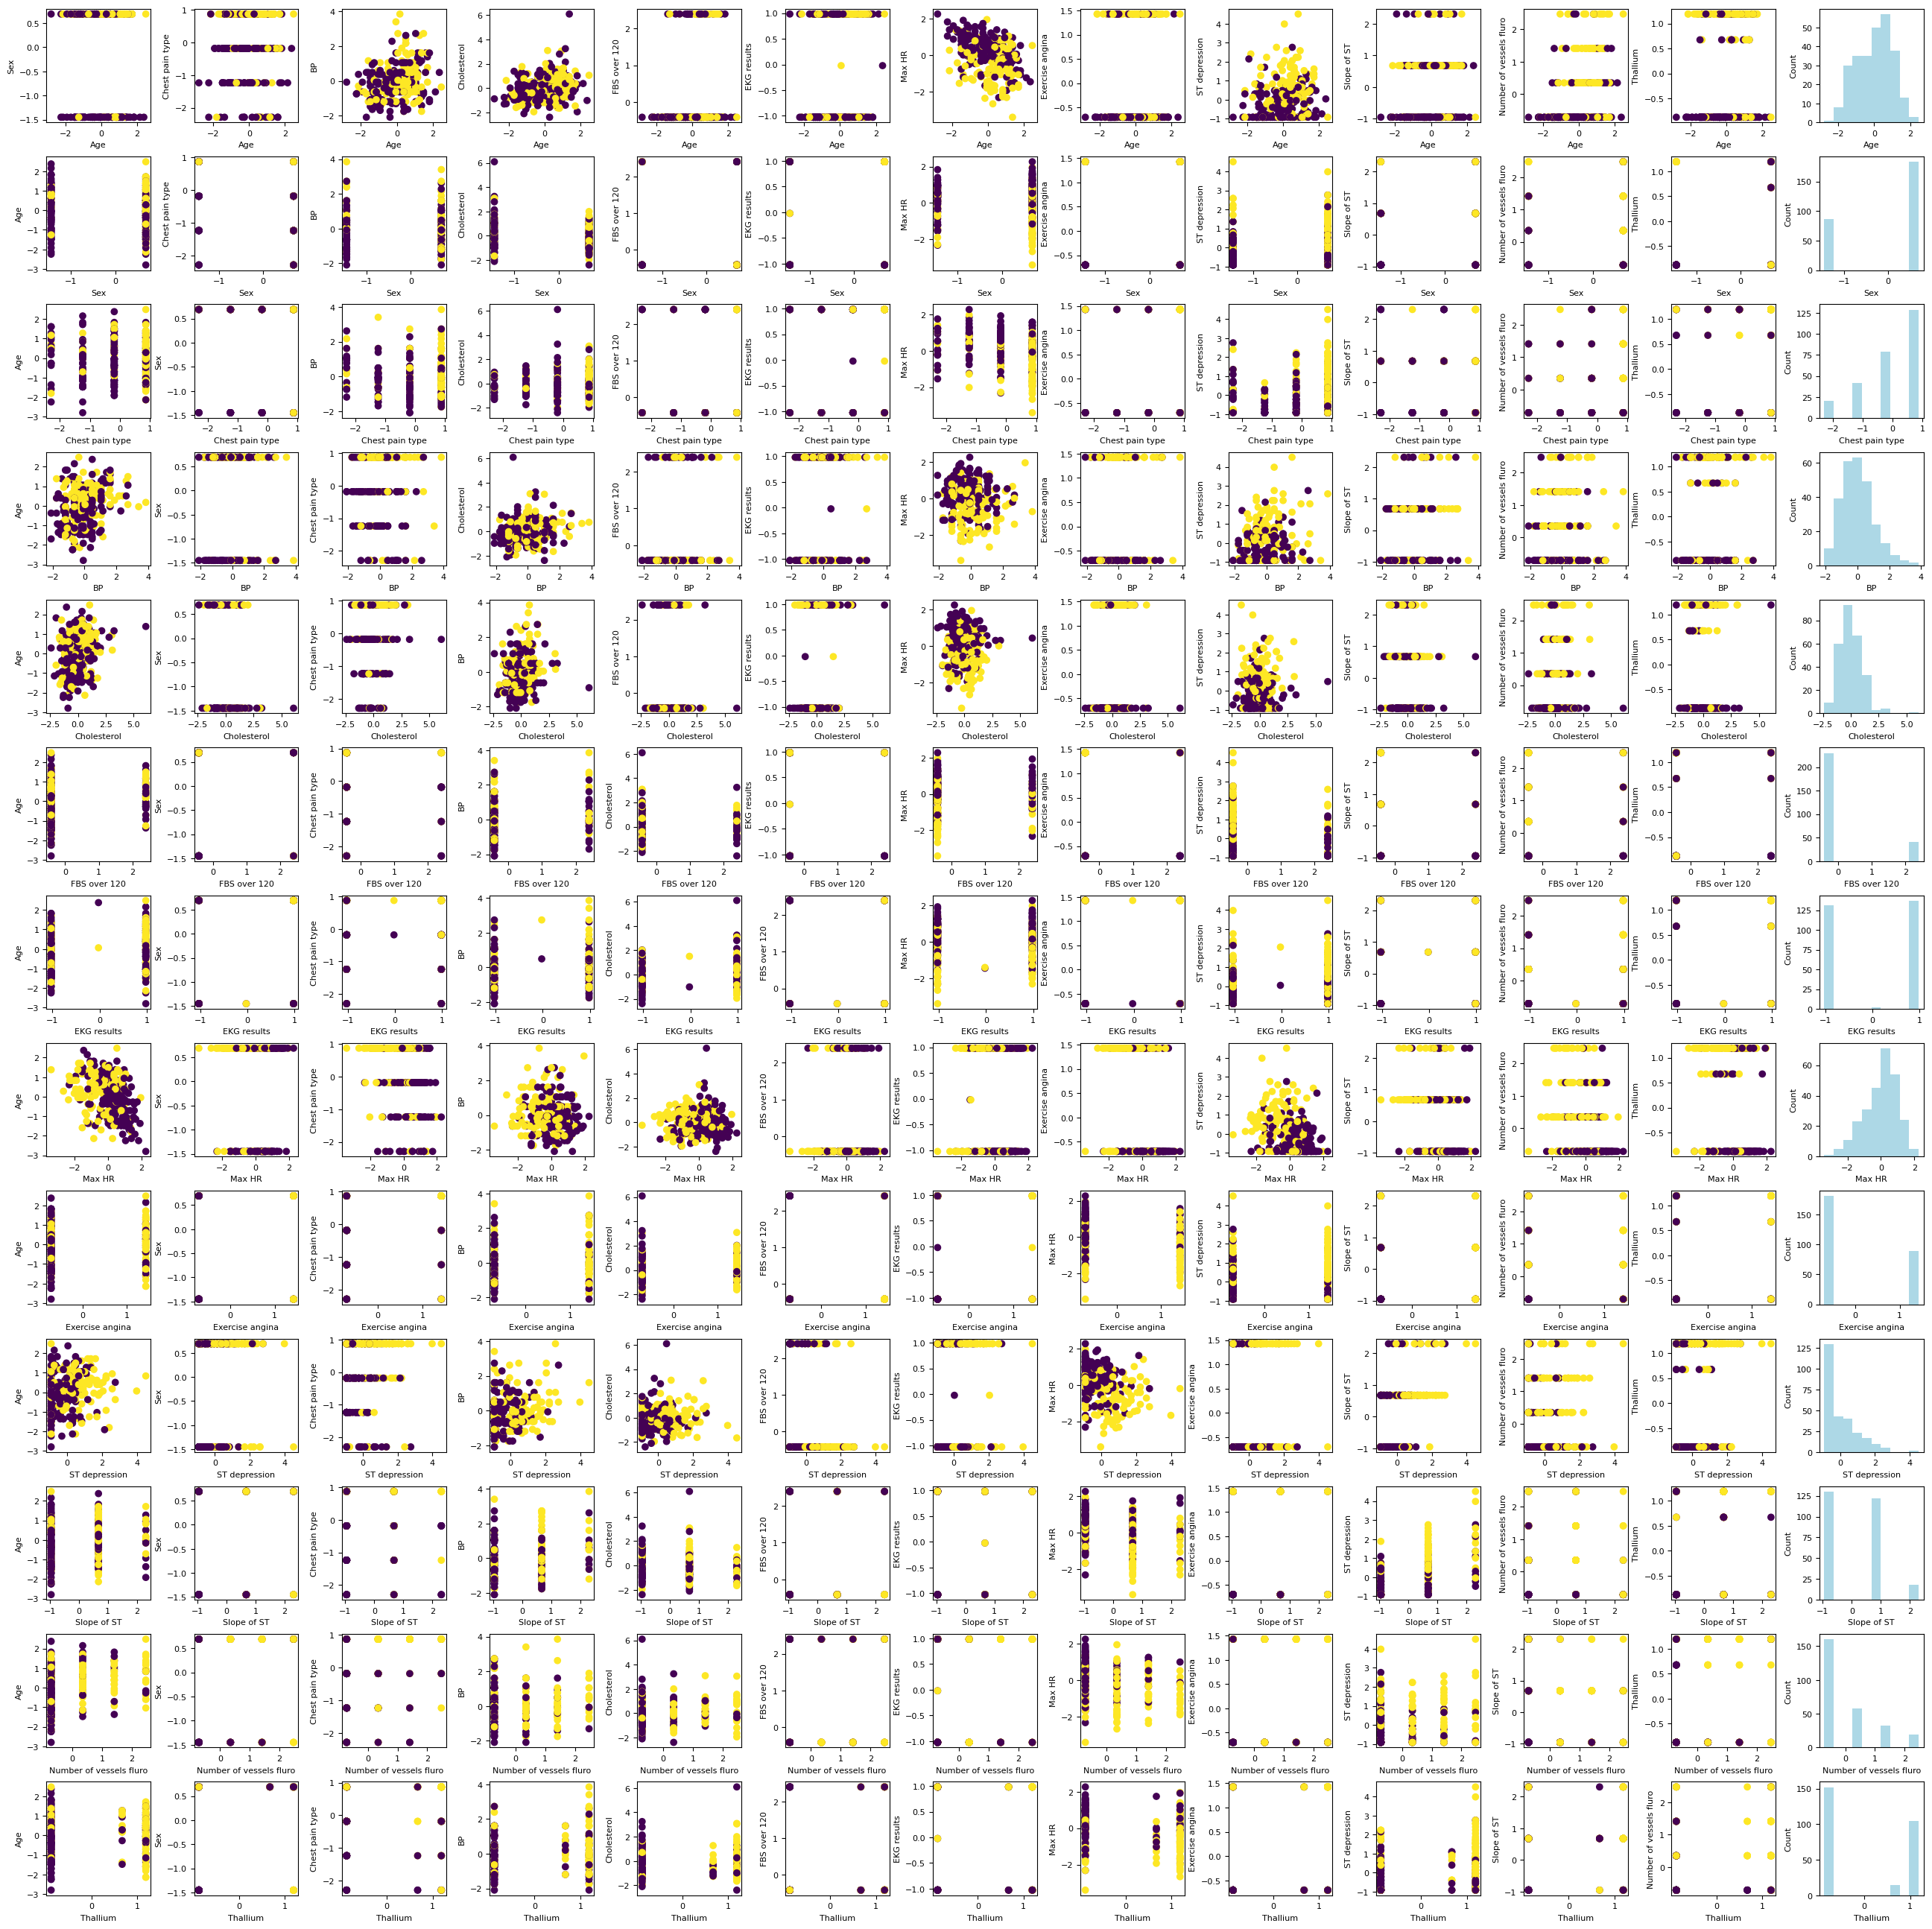

In [20]:
%matplotlib inline

fig, ax = plt.subplots(nrows=n_features, ncols=n_features, figsize= (n_features*2, n_features*2))
fig.tight_layout(pad=2.0)

names = feature_names

for i in range(n_features):
    J = np.arange(n_features)
    J = np.delete(J, i)
    for k, j in enumerate(J):
        ax[i, k].scatter(X_std[:, i], X_std[:, j], c = y)
        ax[i, k].set_xlabel(names[i])
        ax[i, k].set_ylabel(names[j])
        
for i in range(n_features):
    ax[i, -1].hist(X_std[:, i], color = 'lightblue')
    ax[i, -1].set_ylabel('Count')
    ax[i, -1].set_xlabel(names[i])

### Covariance matrix

Defintion:

$$\left[\begin{array}{cccc}\operatorname{Var}\left(x_1\right) & \cdots & \operatorname{Cov}\left(x_{n}, x_1\right) \\ \vdots & \ddots & & \vdots \\ \vdots & \ddots & \vdots \\ \operatorname{Cov}\left(x_{n,}, x_1\right) & \cdots & \operatorname{Var}^2\left(x_{n}\right)\end{array}\right]$$

where:

$$\operatorname{Cov}(x, y)=\frac{\sum(x-\bar{x})(y-y)}{N-1}$$

and

$$\operatorname{Var}(x)=\frac{\sum(x-\bar{x})^2}{N-1}$$

In [13]:
cov_mat = np.cov(X_std.T) # square symmetric, positive semi-definite
cov_mat

array([[ 1.0037175 , -0.09475162,  0.09728006,  0.27406787,  0.22087436,
         0.12391697,  0.12864744, -0.40371067,  0.09866197,  0.194956  ,
         0.16036758,  0.35740431,  0.10649421],
       [-0.09475162,  1.00371742,  0.03476431, -0.06292645, -0.20239707,
         0.04229632,  0.03939937, -0.07638436,  0.18069106,  0.09777398,
         0.05073272,  0.08715272,  0.39250009],
       [ 0.09728006,  0.03476431,  1.00371739, -0.0433567 ,  0.09080145,
        -0.09890316,  0.07460154, -0.318863  ,  0.3544727 ,  0.16786573,
         0.13740864,  0.22672927,  0.26363509],
       [ 0.27406787, -0.06292645, -0.0433567 ,  1.00371745,  0.17366236,
         0.15625975,  0.11658929, -0.03928114,  0.08310042,  0.22362807,
         0.14300161,  0.08601599,  0.13253595],
       [ 0.22087436, -0.20239707,  0.09080145,  0.17366236,  1.00371741,
         0.02527957,  0.1682748 , -0.01880885,  0.07853339,  0.02781217,
        -0.00577668,  0.12701189,  0.02894328],
       [ 0.12391697,  0.042296

### Singular Value Decompostion

Defintion:

$$ A=U \Sigma V^T$$

For square symmetric positive semi-definite matrix (such as covariance matrix), the eigenvalues and $\operatorname{diag}(\Sigma)$ are exactly the same and $U$ is the Eigen-vector matrix.

In [14]:
U, S, Vh = np.linalg.svd(cov_mat)
eig_vals = S
eig_vecs = U

print(S)
print()
print(U)

[3.05663989 1.61364437 1.24574994 1.16500418 1.01614376 0.91198713
 0.82895901 0.75213416 0.68013233 0.57827936 0.45519716 0.4043301
 0.34012594]

[[-0.28234584  0.42118917  0.04612416 -0.13867218 -0.36531265 -0.10016427
  -0.1565326   0.36633942 -0.15252687 -0.19825161 -0.01334038  0.59599019
  -0.03714072]
 [-0.1303346  -0.46471021 -0.36053198 -0.33923722  0.17495453 -0.09126925
  -0.2443882   0.244672   -0.21625585 -0.0342688   0.54534289  0.03024492
  -0.13118077]
 [-0.27235365 -0.15206989  0.49017226 -0.20065339  0.10493556  0.06922638
   0.2253854  -0.1653792   0.48948633 -0.42101082  0.30843349  0.12010089
  -0.04257419]
 [-0.17307788  0.37595705 -0.35650328  0.0891682   0.1311112   0.48732131
  -0.05620147  0.36497784  0.45608246  0.01201499  0.11796817 -0.25992667
  -0.11393512]
 [-0.10114242  0.45040891  0.24550976 -0.15315339  0.39051247  0.31068226
  -0.08043397 -0.28238414 -0.54811348 -0.02568822  0.22735006 -0.12171769
  -0.01859108]
 [-0.04909961  0.21992009 -0.51521436 

### Correct the Eigen Matrix

__This section is actually optional. This step is necessary if we want to keep our results identical to PCA from scikit-learn.__

Correct the Eigen matrix such that:
* for each column, find the __largest absolute__ value
* if the __largest absolute__ value comes from a negative value, make it positive by multiplying the entire column with -1

In [15]:
from numpy.linalg import eig

# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
eig_vecs_ = eig_vecs*signs[np.newaxis,:]

print(eig_vals)
print()
print(eig_vecs_)

[3.05663989 1.61364437 1.24574994 1.16500418 1.01614376 0.91198713
 0.82895901 0.75213416 0.68013233 0.57827936 0.45519716 0.4043301
 0.34012594]

[[ 0.28234584 -0.42118917 -0.04612416 -0.13867218 -0.36531265  0.10016427
  -0.1565326   0.36633942  0.15252687 -0.19825161  0.01334038  0.59599019
   0.03714072]
 [ 0.1303346   0.46471021  0.36053198 -0.33923722  0.17495453  0.09126925
  -0.2443882   0.244672    0.21625585 -0.0342688  -0.54534289  0.03024492
   0.13118077]
 [ 0.27235365  0.15206989 -0.49017226 -0.20065339  0.10493556 -0.06922638
   0.2253854  -0.1653792  -0.48948633 -0.42101082 -0.30843349  0.12010089
   0.04257419]
 [ 0.17307788 -0.37595705  0.35650328  0.0891682   0.1311112  -0.48732131
  -0.05620147  0.36497784 -0.45608246  0.01201499 -0.11796817 -0.25992667
   0.11393512]
 [ 0.10114242 -0.45040891 -0.24550976 -0.15315339  0.39051247 -0.31068226
  -0.08043397 -0.28238414  0.54811348 -0.02568822 -0.22735006 -0.12171769
   0.01859108]
 [ 0.04909961 -0.21992009  0.51521436 

### Select the Axis Components

In [28]:
# Select top k eigenvectors
k = 3
W = eig_vecs_[:, :k] # Projection matrix
print(W)
print(W.shape)

[[ 0.28234584 -0.42118917 -0.04612416]
 [ 0.1303346   0.46471021  0.36053198]
 [ 0.27235365  0.15206989 -0.49017226]
 [ 0.17307788 -0.37595705  0.35650328]
 [ 0.10114242 -0.45040891 -0.24550976]
 [ 0.04909961 -0.21992009  0.51521436]
 [ 0.14938251 -0.22023141  0.03679863]
 [-0.39245121 -0.03866031  0.22492929]
 [ 0.33781379  0.19451712 -0.17807517]
 [ 0.3963331   0.04466736  0.15492987]
 [ 0.3659821   0.05850108  0.16385894]
 [ 0.2975153  -0.14524784 -0.02972413]
 [ 0.34136678  0.27675662  0.19852029]]
(13, 3)


### Transform the Dataset

In [33]:
X_proj = X_std.dot(W)
print(X_proj.shape)

(270, 3)


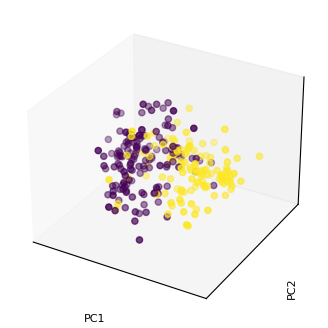

In [34]:
%matplotlib inline

fig = plt.figure(figsize=(4,4));
ax = fig.add_subplot(projection='3d');

ax.scatter(X_proj[:, 0], X_proj[:, 1],  X_proj[:, 2], c = y);

ax.set_xlabel('PC1');
ax.set_xticks([]);
ax.set_ylabel('PC2', rotation=90);
ax.set_yticks([]);
ax.set_zlabel('PC3', rotation=90);
ax.set_zticks([]);

### Explained Variance

The optimal value for `k` can be tuned by investigating the explained variance. 

The explained variance tells us how much information (variance) can be attributed to each of the principal components.

$$
\text{Explained variance} = \frac{\sum_{i=0}^{r} \lambda_i}{\sum_{i=0}^{m} \lambda_i} = \frac{\lambda_1 + \lambda_2 + \cdots + \lambda_m}{\lambda_1 + \lambda_2 + \cdots + \lambda_r}
$$

where: $r<= m$ 

Explained variance: [23.43 12.37  9.55  8.93  7.79  6.99  6.35  5.76  5.21  4.43  3.49  3.1
  2.61]
Cumulative explained variance: [ 23.43  35.8   45.35  54.28  62.07  69.06  75.41  81.17  86.38  90.81
  94.3   97.4  100.01]


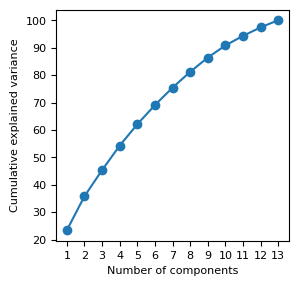

In [35]:
%matplotlib inline

eig_vals_total = sum(eig_vals)
explained_variance = [(i / eig_vals_total)*100 for i in eig_vals]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

print('Explained variance: {}'.format(explained_variance))
print('Cumulative explained variance: {}'.format(cum_explained_variance))

fig, ax = plt.subplots(figsize= (3, 3))

ax.plot(np.arange(1,n_features+1), cum_explained_variance, '-o')
ax.set_xticks(np.arange(1,n_features+1))
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

## References:

* [Principal Component Analysis from Scratch](https://bagheri365.github.io/blog/Principal-Component-Analysis-from-Scratch/)
* [Principal component analysis. Nat Rev Methods Primers 2, 100 (2022)](https://pure.eur.nl/ws/portalfiles/portal/95076086/Nature_Reviews_Methods_Primer_Greenacre_et_al_2022_PCA.pdf)
* [MIT OCW, Statistics for Applications, Chapter 9: Principal Component Analysis (PCA)](https://ocw.mit.edu/courses/18-650-statistics-for-applications-fall-2016/d85e1a9d113142ade8ce5e4f5ef0b4e8_MIT18_650F16_PCA.pdf)